# Correcting Masks

The notebook dedicated to start the program to perform masks correction for selected images.

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.enums import Resampling
import os
import tarfile
import napari
import sys
from qtpy.QtWidgets import QApplication
from pathlib import Path


In [ ]:
project_root = os.getenv('PROJECT_ROOT_PATH')
corrections_path = os.getenv('CORRECTIONS_PATH')

# Add the project root path to the system path
sys.path.append(project_root)

#necessary imports
from scripts.data_preparation.masks_creation import *

#### Code for mask correction

In [2]:
WATER_VALUES = [6]  # Water class in SCL
ICE_VALUES = [2, 11]  # Water class in SCL

    # RGB color map
MASK_COLORS = {
    0: (0, 0, 0),          # Background (black or unused)
    2: (0, 0, 255),        # Water (blue)
    3: (0, 255, 0),        # Snow/Ice (green)
}

In [ ]:
%gui qt5

# ──────────────────────────────────────────────────────────────────────────────
# CONFIGURATION
DIR = corrections_path
CURRENTQ = "/wbQ42024"
DATA_DIR = DIR + CURRENTQ

OUT_DIR  = DATA_DIR + "/Corrected"
os.makedirs(OUT_DIR, exist_ok=True)
# ──────────────────────────────────────────────────────────────────────────────

scene_ids = []
for name in os.listdir(DATA_DIR):
    folder = os.path.join(DATA_DIR, name)
    tar    = os.path.join(folder, "response.tar")

    if os.path.isdir(folder) and os.path.exists(tar):
        scene_ids.append(name)

print("Found scene folders:", scene_ids)

for ID in scene_ids:
    tar = os.path.join(DATA_DIR, ID, "response.tar")
    print("→", tar)
    if not os.path.exists(tar):
        continue

    print(f"Processing {ID}…")
    data_dict = read_dataset_tar(tar)

    rgb_scaled = create_rgb(data_dict['rgb_nir'][:3])
    ndwi_img = create_ndwi(data_dict['green_band'], data_dict['nir_band'])
    ndwi_mask = create_ndwi_mask(ndwi_img)
    scl_mask = create_scl_masks(data_dict['scl_band'], WATER_VALUES, ICE_VALUES,MASK_COLORS) 
    mask = create_combined_mask(data_dict['scl_band'],data_dict['cld_band'], 15, rgb_scaled, WATER_VALUES, ICE_VALUES, MASK_COLORS)
    mask_extended = create_combined_mask_with_ndwi(data_dict['scl_band'],data_dict['cld_band'], 15, rgb_scaled, ndwi_mask,WATER_VALUES, ICE_VALUES, MASK_COLORS)
    mask_final = final_mask(data_dict['scl_band'],data_dict['cld_band'], 15, rgb_scaled, ndwi_mask, WATER_VALUES, ICE_VALUES, MASK_COLORS)
    
    rgb       = create_rgb(data_dict['rgb_nir'][:3])
    ndwi      = create_ndwi(data_dict['green_band'], data_dict['nir_band'])

    ndwi_rgb  = create_ndwi_mask(ndwi)           # shape (H,W,3)
    ndwi_bool = (ndwi_rgb[...,0] == 255)        

    combined_rgb = final_mask(
        data_dict['scl_band'],
        data_dict['cld_band'],
        15,
        rgb,
        ndwi_rgb, WATER_VALUES, ICE_VALUES, MASK_COLORS,
    )
    combined_lbl = final_label_mask(
        data_dict['scl_band'],
        data_dict['cld_band'],
        15,
        ndwi_bool, WATER_VALUES, ICE_VALUES, MASK_COLORS
    )


    print(f"Editing {ID}…  water/cloud counts:",
          )

    print("   ➡ Napari window…  (press ‘s’ to save, then close)")
    viewer = napari.Viewer(title=f"Edit {ID}")
    viewer.add_image(rgb,          name="RGB",      blending='additive')
    viewer.add_image(combined_rgb, name="Preview",  opacity=0.3)

    labels = viewer.add_labels(combined_lbl, name="Labels", opacity=0.6)

    labels.color = {
        0: (0, 0, 0, 0.0),      # background transparent
        1: (0, 0, 1, 0.5),      # water = blue 50%
        2: (0, 1, 0, 0.5),      # ice/snow = green 50%
        3: (1, 0, 0, 0.5),      # cloud = red 50%
        4: (0, 1, 1, 0.5),      # NDWI only = cyan 50%
    }

    @viewer.bind_key('s')
    def save(viewer):
        out = os.path.join(OUT_DIR, f"{ID}.npy")
        np.save(out, labels.data.astype(np.uint8))
        print("Saved →", out)

     # ––– RAISING + EVENT LOOP –––
    app = QApplication.instance()

    target_title = f"Edit {ID}"
    qt_win = None
    for w in app.topLevelWidgets():
    
        if hasattr(w, "windowTitle") and w.windowTitle() == target_title:
            qt_win = w
            break
    if qt_win is None:
        print("Could not find Qt window for", target_title)
    else:
        qt_win.show()
        qt_win.raise_()
        qt_win.activateWindow()

    while qt_win.isVisible():
        app.processEvents()

    print(f"Done with {ID}\n")


#### Checking output

Processing folder: 4b2910a26a7a7840da47fd71865c7160


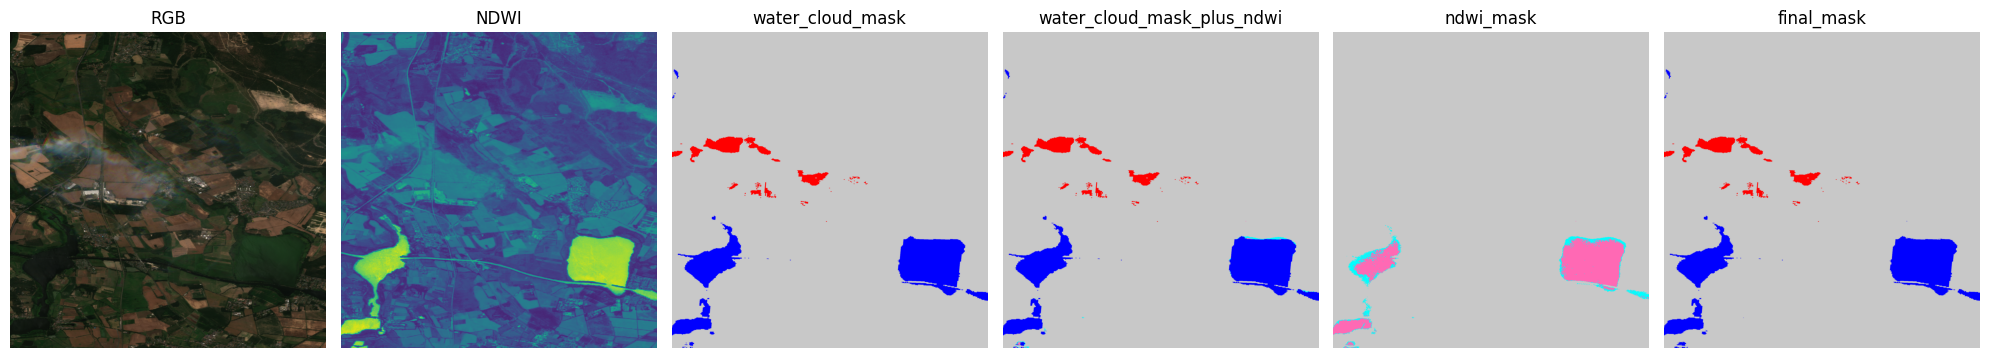

Processing folder: 0d56ccefa3b0f3750fce55e97b500c02


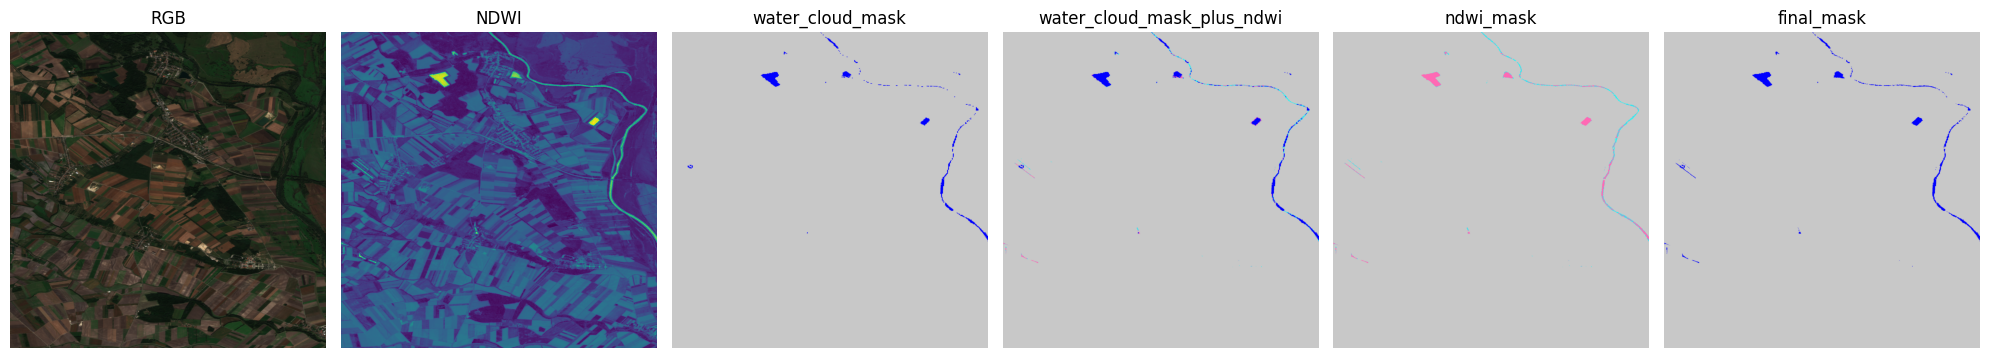

Processing folder: 804abc606c0c9bfb2a60a30369244152


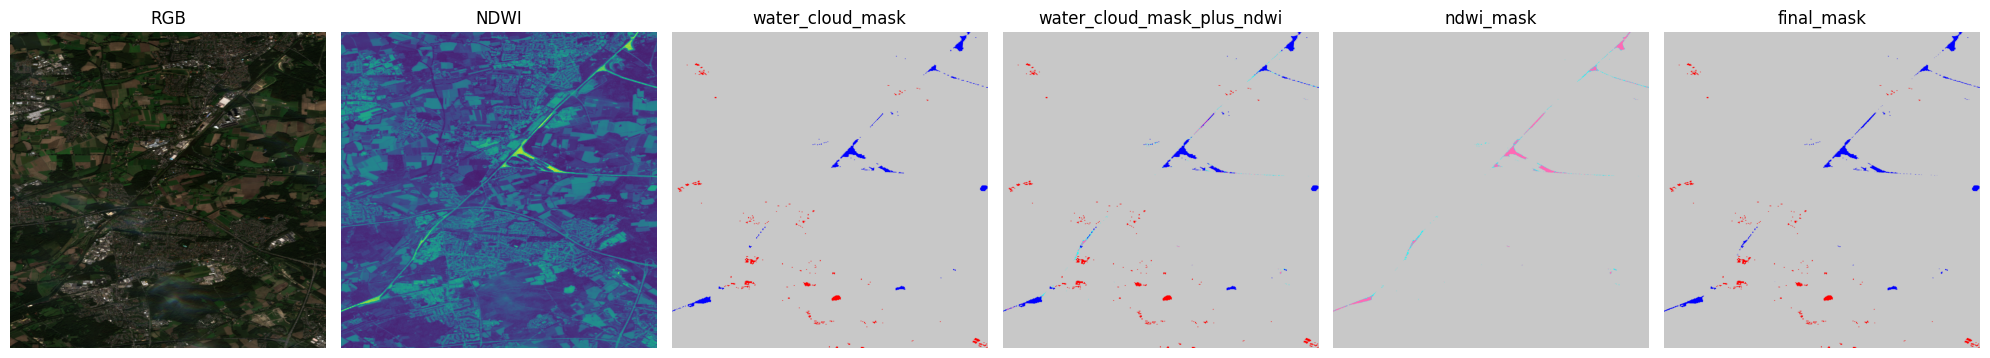

Processing folder: c43bb40bcbd6ac27e45d4399f2155079


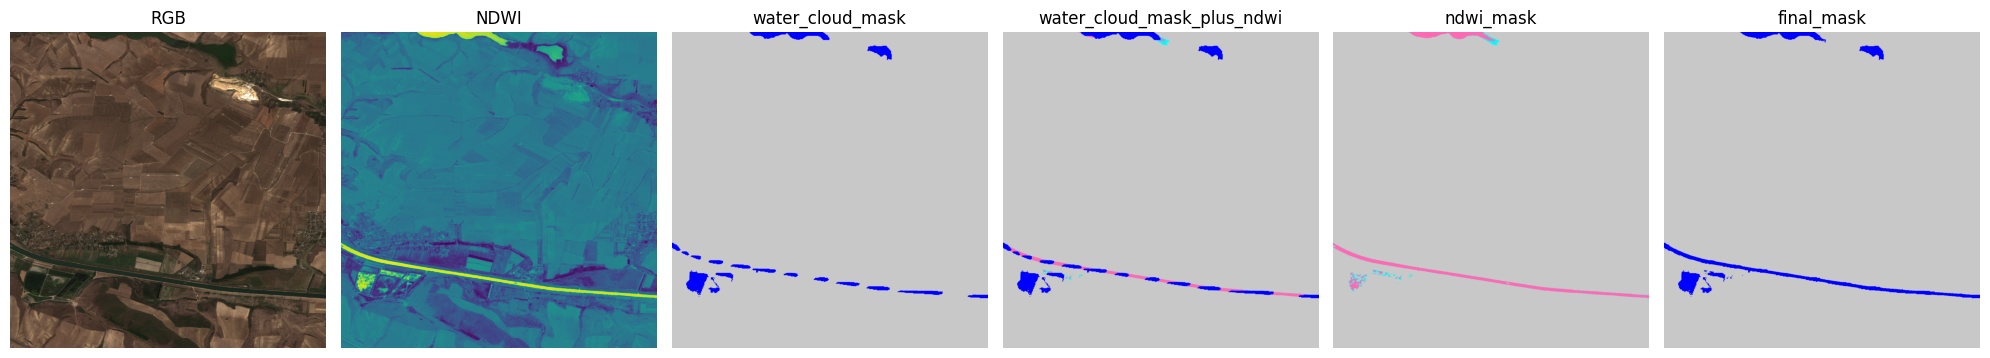

Processing folder: Corrected
response.tiff not found in /Users/viktoriiaovsianik/Documents/Uni/04_WS2024/04_Project/Masks Corrections/wbQ32023/Corrected


In [ ]:
data_path = corrections_path

stats = {'n_with_cloud':0,'n_with_water':0,'n_with_both':0, 'n_with_nothing':0}

for folder_name in os.listdir(data_path)[0:50]:   
    folder_path = os.path.join(data_path, folder_name)
    if os.path.isdir(folder_path):  # Check if it's a directory
        print(f"Processing folder: {folder_name}")
        file_name = '/response.tar' #simplified filename
        file_path = folder_path + file_name
        if os.path.exists(file_path):

            data_dict = read_dataset_tar(file_path)

            rgb_scaled = create_rgb(data_dict['rgb_nir'][:3])
            ndwi_img = create_ndwi(data_dict['green_band'], data_dict['nir_band'])
            ndwi_mask = create_ndwi_mask(ndwi_img)
            scl_mask = create_scl_masks(data_dict['scl_band'], WATER_VALUES, ICE_VALUES,MASK_COLORS) 
            mask = create_combined_mask(data_dict['scl_band'],data_dict['cld_band'], 15, rgb_scaled, WATER_VALUES, ICE_VALUES, MASK_COLORS)
            mask_extended = create_combined_mask_with_ndwi(data_dict['scl_band'],data_dict['cld_band'], 15, rgb_scaled, ndwi_mask,WATER_VALUES, ICE_VALUES, MASK_COLORS)
            mask_final = final_mask(data_dict['scl_band'],data_dict['cld_band'], 15, rgb_scaled, ndwi_mask, WATER_VALUES, ICE_VALUES, MASK_COLORS)
            visualize_images(rgb_scaled, ndwi_img,  mask, mask_extended, ndwi_mask, mask_final)


        else:
            print(f"response.tiff not found in {folder_path}")
    else:
        print(f"Skipping {folder_name}, it's not a directory")


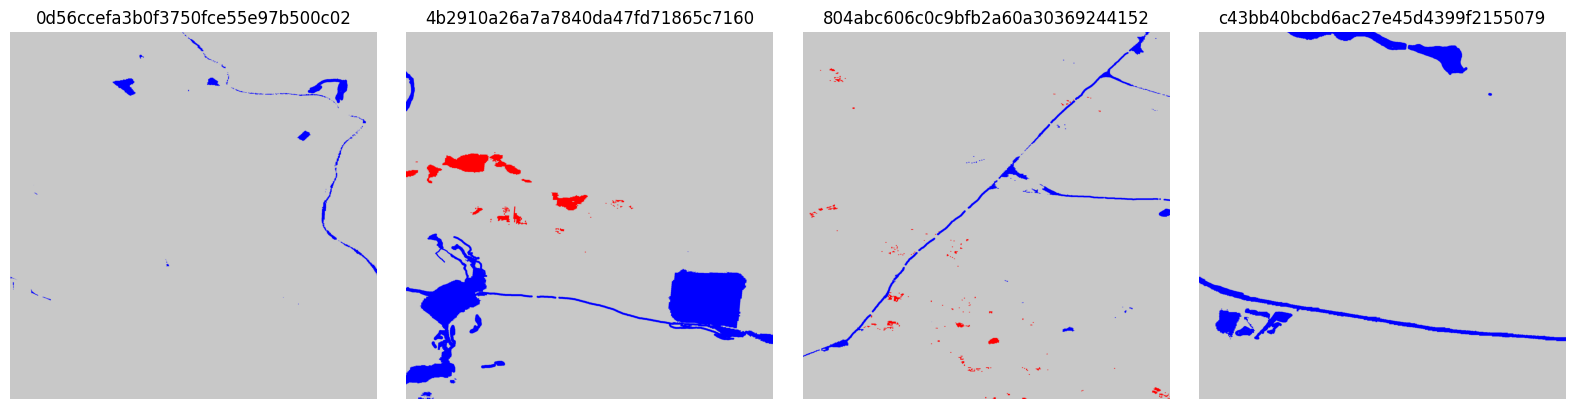

In [ ]:
path = OUT_DIR

input_folder = Path(path)


npy_files = sorted(input_folder.glob("*.npy"))
n_display = min(len(npy_files), 5)

plt.figure(figsize=(4 * n_display, 4))  

for i, npy_file in enumerate(npy_files[:n_display]):
    labels = np.load(npy_file)
    H, W = labels.shape
    mask_rgb = np.zeros((H, W, 3), dtype=np.uint8)

    # Assign colors
    mask_rgb[labels == 0] = (200, 200, 200)  # background
    water_pixels = (labels == 1) | (labels == 4)
    mask_rgb[water_pixels] = (0, 0, 255)     # water
    mask_rgb[labels == 2] = (0, 255, 0)      # ice/snow
    mask_rgb[labels == 3] = (255, 0, 0)      # cloud

    # Plot in a single row
    plt.subplot(1, n_display, i + 1)
    plt.imshow(mask_rgb)
    plt.title(npy_file.stem)
    plt.axis('off')

plt.tight_layout()
plt.show()
